In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path

In [270]:
from datetime import date
def create_dataset(rawpath, modelpath, calibpath):
    def add_attrs_variables(dataset_input, 
                        variable_name, 
                        long_name, 
                        unit, 
                        resolution, 
                        height_of_calibration):
#         dataset_input[variable_name].attrs['long_name'] = f'{long_name}'
#         dataset_input[variable_name].attrs['unit'] = f'{unit}'
#         dataset_input[variable_name].attrs['resolution'] = f'{resolution}'
#         dataset_input[variable_name].attrs['calibration_height [m]'] = f'{height_of_calibration}'
        dict_attrs = {
            "long_name":long_name,
            "unit":unit,
            "resolution":resolution,
            "height_of_calibration":height_of_calibration
        }

        for key, value in dict_attrs.items():
            if value is not None:
                dataset_input[variable_name].attrs[key]= value 
        
        return dataset_input
    print('add coords')
    # coords
    time = xr.open_dataset(rawpath)['time'].values
    range = xr.open_dataset(rawpath)['range'].values
    altitude = xr.open_dataset(rawpath)['altitude'].values + range
    print('add raw signal')
    # Raw
    Raw_AnalogNR_None_355 = xr.open_dataset(rawpath)['rcs_12'].values
    Raw_AnalogNR_None_532 = xr.open_dataset(rawpath)['rcs_16'].values
    latitude = xr.open_dataset(rawpath)['lat'].values
    latitude = np.round(lat, 3)
    longitude = xr.open_dataset(rawpath)['lon'].values
    longitude = np.round(lon, 3)
    print('add thermo model')
    # Thermo
    Pressure = pd.read_pickle(modelpath)['pression'].unstack(level=1).values
    Temperature = pd.read_pickle(modelpath)['ta'].unstack(level=1).values
    # Model 
    Model_Molecular_Backscatter_532 = pd.read_pickle(modelpath)['beta532mol'].unstack(level=1).values
    Model_Molecular_Backscatter_355 = pd.read_pickle(modelpath)['beta355mol'].unstack(level=1).values
    print('add calibrated signal')
    # Calibration 
    Total_Attenuated_Molecular_Backscatter_532 = xr.open_dataset(calibpath)['simulated'].sel(wavelength = 532).values
    Total_Attenuated_Molecular_Backscatter_355 = xr.open_dataset(calibpath)['simulated'].sel(wavelength = 355).values
    Calibrated_Attenuated_Backscatter_532 = xr.open_dataset(calibpath)['calibrated'].sel(wavelength = 532).values
    Calibrated_Attenuated_Backscatter_355 = xr.open_dataset(calibpath)['calibrated'].sel(wavelength = 355).values
    Total_ScaterringRatio_532 = Calibrated_Attenuated_Backscatter_532 / Total_Attenuated_Molecular_Backscatter_532
    Total_ScaterringRatio_355 = Calibrated_Attenuated_Backscatter_355 / Total_Attenuated_Molecular_Backscatter_355    
    print('create dataset')
    # dataset
    dataset_to_netcdf = xr.Dataset({
        'Altitude' : (('range'), altitude),
        'Raw_AnalogNR_355' : (('time', 'range'), Raw_AnalogNR_None_355),
        'Raw_AnalogNR_532' : (('time', 'range'), Raw_AnalogNR_None_532), 
        'Model_Pressure' : (('time', 'range'), Pressure),
        'Model_Temperature' : (('time', 'range'), Temperature),
        'Model_Molecular_Backscatter_355' : (('time', 'range'),Model_Molecular_Backscatter_355),
        'Model_Molecular_Backscatter_532' : (('time', 'range'),Model_Molecular_Backscatter_532),
        'Attn_Molecular_Backscatter_355' : (('time', 'range'),Total_Attenuated_Molecular_Backscatter_355),
        'Attn_Molecular_Backscatter_532' : (('time', 'range'),Total_Attenuated_Molecular_Backscatter_532),
        'Total_Calib_Attn_Backscatter_355' : (('time', 'range'),Calibrated_Attenuated_Backscatter_355),
        'Total_Calib_Attn_Backscatter_532' : (('time', 'range'),Calibrated_Attenuated_Backscatter_532), 
        'Total_ScattRatio_355' : (('time', 'range'),Total_ScaterringRatio_355),
        'Total_ScattRatio_532' : (('time', 'range'),Total_ScaterringRatio_532),
        'C_355' : (('time'), [None]*len(time)),
        'C_532' : (('time'), [None]*len(time)),
        },
        coords = {
            'time' : time,
            'range' : range,
        },
        attrs = {
            'Title' : 'SIRTA IPRAL multiwavelength LIDAR L1A data. Range corrected signal with calibration products',
            'Instrument_name' : 'IPSL HiPerformance multi-wavelength Raman Lidar',
            'Station_name' : 'SIRTA',
            'Start_Datetime' : f'{time[0]}',
            'End_Datetime' : f'{time[-1]}',
            'Latitude' : f'{np.round(latitude,3)}',
            'Latitude_unit' : 'degrees_north',
            'Longitude' : f'{np.round(longitude,3)}',
            'Longitude_unit' : 'degrees_east',
            'Responsable_data' : 'N.M.Phuong Nguyen (phuong.nguyen@latmos.ipsl.fr)',
            'Responsable_instrument' : 'Christophe Pietras (christophe.pietras@lmd.ipsl.fr)',
            'Date_data_created' : date.today().strftime('%d/%m/%Y'),
            'version': 'v0.3',
        },
    )
    print('add attrs to variables')
    # add attrs
    dataset_to_netcdf = add_attrs_variables(dataset_to_netcdf, 'Altitude', 
                                           'Altitude of measurements', 'm', altitude[1]-altitude[0], '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Raw_AnalogNR_355',
                                            'Range corrected analog signal at 355nm', 'mV.m^2', None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Raw_AnalogNR_532',
                                            'Range corrected analog signal at 532nm', 'mV.m^2', None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Model_Pressure',
                                            'Pressure above sea level from ERA5 hourly', 'Pa', None, None)
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Model_Temperature',
                                            'Temperature from ERA5 hourly', 'K', None, None )
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Model_Molecular_Backscatter_355',
                                            'Molecular backscatter model at 355nm calculated with Temperature and Pressure fields', 'm^-1.sr^-1', None, None)
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Model_Molecular_Backscatter_532',
                                            'Molecular backscatter model at 532nm calculated with Temperature and Pressure fields', 'm^-1.sr^-1', None, None)
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Attn_Molecular_Backscatter_532',
                                            'Attenuated molecular backscatter at 532nm from molecular backscatter model ', 'm^-1.sr^-1', None, None)
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Attn_Molecular_Backscatter_355',
                                            'Attenuated molecular backscatter at 355nm from molecular backscatter model ', 'm^-1.sr^-1', None, None)
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Total_Calib_Attn_Backscatter_355',
                                            'Calibrated signal of Attenuated Backscatter at 355nm', 'm^-1.sr^-1', None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Total_Calib_Attn_Backscatter_532',
                                            'Calibrated signal of Attenuated Backscatter at 532nm', 'm^-1.sr^-1', None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Total_ScattRatio_355',
                                            'Total scattering ratio of signal at 355nm = Calibrated signal of Attenuated Backscatter / Attenuated molecular backscatter ', None, None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'Total_ScattRatio_532',
                                            'Total scattering ratio of signal at 532nm = Calibrated signal of Attenuated Backscatter / Attenuated molecular backscatter ', None, None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'C_532', 
                                             'Calibration constant for the 532nm signal', None, None, '3000 - 4000')
    dataset_to_netcdf =  add_attrs_variables(dataset_to_netcdf, 'C_355', 
                                             'Calibration constant for the 355nm signal', None, None, '3000 - 4000')
    return dataset_to_netcdf

In [253]:
year = 2018
RAW_DIR = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/', str(year))
MODEL_DIR = Path('/homedata/nmpnguyen/IPRAL/RF/Simul/')
CALIB_DIR = Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/')

In [254]:
RAW_PATH = sorted(RAW_DIR.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))[2]
MODEL_PATH = sorted(MODEL_DIR.glob(f'{RAW_PATH.stem}*'))[0]
CALIB_PATH = sorted(CALIB_DIR.glob(f'{RAW_PATH.name}'))[0]
RAW_PATH, MODEL_PATH, CALIB_PATH

(PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/02/23/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc'),
 PosixPath('/homedata/nmpnguyen/IPRAL/RF/Simul/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440_simul.pkl'),
 PosixPath('/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc'))

In [255]:
f'ipral_calib_v01_{rawpath.name.split("v01_")[1]}'

'ipral_calib_v01_20180223_000000_1440.nc'

In [271]:
MODEL_PATH, CALIB_PATH, RAW_PATH
for rawpath in sorted(RAW_DIR.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))[:1]: 
    modelpath = sorted(MODEL_DIR.glob(f'{rawpath.stem}*'))[0]
    calibpath = sorted(CALIB_DIR.glob(f'{rawpath.name}'))[0]
    print(modelpath, calibpath)
    if (not rawpath) | (not modelpath) | (not calibpath):
        print('Not Found Files')
        pass
    dataset_to_write = create_dataset(rawpath, modelpath, calibpath)
#     dataset_to_write.to_netcdf(f'/homedata/nmpnguyen/IPRAL/NETCDF/ipral_calib_v01_{rawpath.name.split("v01_")[1]}', 'w')

/homedata/nmpnguyen/IPRAL/RF/Simul/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440_simul.pkl /homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc
add coords
add raw signal
add thermo model
add calibrated signal
create dataset
add attrs to variables


In [273]:
dataset_to_write

<xarray.Dataset>
Dimensions:                           (range: 4000, time: 817)
Coordinates:
  * time                              (time) datetime64[ns] 2018-02-21T12:05:...
  * range                             (range) float32 15.0 30.0 ... 6e+04
Data variables: (12/15)
    Altitude                          (range) float32 171.0 186.0 ... 6.016e+04
    Raw_AnalogNR_355                  (time, range) float64 205.9 ... 3.301e+09
    Raw_AnalogNR_532                  (time, range) float64 1.05e+03 ... 1.67...
    Model_Pressure                    (time, range) float64 1.011e+05 ... -409.7
    Model_Temperature                 (time, range) float64 276.9 ... 280.0
    Model_Molecular_Backscatter_355   (time, range) float64 9.217e-06 ... -9....
    ...                                ...
    Total_Calib_Attn_Backscatter_355  (time, range) float64 -1.691e-11 ... -4...
    Total_Calib_Attn_Backscatter_532  (time, range) float64 -1.068e-10 ... -3...
    Total_ScattRatio_355              (time, range) float64 -1.957e-06 ... 4....
    Total_ScattRatio_532              (time, range) float64 -6.464e-05 ... 6....
    C_355                             (time) object None None None ... None None
    C_532                             (time) object None None None ... None None
Attributes: (12/13)
    Title:                   SIRTA IPRAL multiwavelength LIDAR L1A data. Rang...
    Instrument_name:         IPSL HiPerformance multi-wavelength Raman Lidar
    Station_name:            SIRTA
    Start_Datetime:          2018-02-21T12:05:33.000000256
    End_Datetime:            2018-02-21T21:14:51.000000000
    Latitude:                48.71799850463867
    ...                      ...
    Longitude:               2.2070000171661377
    Longitude_unit:          degrees_east
    Responsable_data:        N.M.Phuong Nguyen (phuong.nguyen@latmos.ipsl.fr)
    Responsable_instrument:  Christophe Pietras (christophe.pietras@lmd.ipsl.fr)
    Date_data_created:       03/03/2022
    version:                 v0.3

In [140]:
# 355
# Raw_AnalogFR_parallel_355 = xr.open_dataset(RAW_PATH)['rcs_02'].values
# Raw_AnalogFR_perpendicular_355 = xr.open_dataset(RAW_PATH)['rcs_04'].values
# Raw_PhotoctFR_parallel_355 = xr.open_dataset(RAW_PATH)['rcs_03'].values
# Raw_PhotoctFR_perpendicular_355 = xr.open_dataset(RAW_PATH)['rcs_05'].values
# Raw_AnalogNR_None_355 = xr.open_dataset(RAW_PATH)['rcs_12'].values
Raw_AnalogNR_None_355 = xr.open_dataset(RAW_PATH)['rcs_12'].values

# 532
# Raw_PhotoctFR_None_532 = xr.open_dataset(RAW_PATH)['rcs_10'].values
# Raw_AnalogFR_None_532 = xr.open_dataset(RAW_PATH)['rcs_11'].values
# Raw_PhotoctNR_None_532 = xr.open_dataset(RAW_PATH)['rcs_17'].values
Raw_AnalogNR_None_532 = xr.open_dataset(RAW_PATH)['rcs_16'].values

# Lat-Lon
lat = xr.open_dataset(RAW_PATH)['lat'].values
lat = np.round(lat, 3)
print(lat)
lon = xr.open_dataset(RAW_PATH)['lon'].values
lon = np.round(lon, 3)
print(lon)

48.718
2.207


In [141]:
# coords
# time = xr.open_dataset(RAW_PATH)['time'].values
# range = xr.open_dataset(RAW_PATH)['range'].values
# altitude = xr.open_dataset(RAW_PATH)['altitude'].values + range

In [142]:
# Thermo
Pressure = pd.read_pickle(MODEL_PATH)['pression'].unstack(level=1).values
Temperature = pd.read_pickle(MODEL_PATH)['ta'].unstack(level=1).values

In [143]:
# Model 
Model_Molecular_Backscatter_532 = pd.read_pickle(MODEL_PATH)['beta532mol'].unstack(level=1).values
Model_Molecular_Backscatter_355 = pd.read_pickle(MODEL_PATH)['beta355mol'].unstack(level=1).values
# Model_Molecular_Extinction_532 = Model_Molecular_Backscatter_532/0.119
# Model_Molecular_Extinction_355 = Model_Molecular_Backscatter_355/0.119

In [147]:
# Calibration 
Total_Attenuated_Molecular_Backscatter_532 = xr.open_dataset(CALIB_PATH)['simulated'].sel(wavelength = 532).values
Total_Attenuated_Molecular_Backscatter_355 = xr.open_dataset(CALIB_PATH)['simulated'].sel(wavelength = 355).values
Calibrated_Attenuated_Backscatter_532 = xr.open_dataset(CALIB_PATH)['calibrated'].sel(wavelength = 532).values
Calibrated_Attenuated_Backscatter_355 = xr.open_dataset(CALIB_PATH)['calibrated'].sel(wavelength = 355).values
Total_ScaterringRatio_532 = Calibrated_Attenuated_Backscatter_532 / Total_Attenuated_Molecular_Backscatter_532
Total_ScaterringRatio_355 = Calibrated_Attenuated_Backscatter_355 / Total_Attenuated_Molecular_Backscatter_355

In [146]:
Total_Attenuated_Molecular_Backscatter_532.shape, Calibrated_Attenuated_Backscatter_532.shape

((1234, 4000), (1234, 4000))

In [160]:
# mask

#______LOAD FONCTION______
import sys
sys.path.append('/scratchx/nmpnguyen/IPRAL/raw/detection_clouds_test/')
from imp import reload as rl
import flag_functions


In [220]:
rl(flag_functions)
from flag_functions import filter_profile_file, validated_profile, ipral_remove_cloud_profiles

In [221]:
dataraw = xr.open_dataset(RAW_PATH)
Raw_AnalogNR_None_355_corr = (dataraw['rcs_12']/np.square(dataraw['range']) - dataraw['bckgrd_rcs_12'])*np.square(dataraw['range'])
# Raw_AnalogNR_None_355_corr = Raw_AnalogNR_None_355_corr.values

In [222]:
range_limite_top = [26000,28000]
range_limite_bottom = [2000,3000]
mask_crit1 = filter_profile_file(Raw_AnalogNR_None_355_corr, 'rcs_12', range_limite_top, range_limite_bottom)

mask_crit1.astype('int')*(2**2)

<xarray.DataArray (time: 1234)>
array([4, 0, 0, ..., 4, 4, 4])
Coordinates:
  * time     (time) datetime64[ns] 2018-02-23T11:38:07.000000256 ... 2018-02-...

In [223]:
limitez = (dataraw['range']<20000)
mask_crit2 = validated_profile(Raw_AnalogNR_None_355_corr.isel(range=limitez))

mask_crit2.astype('int')*(2**1)

<xarray.DataArray (time: 1234)>
array([0, 0, 0, ..., 2, 2, 2])
Coordinates:
  * time     (time) datetime64[ns] 2018-02-23T11:38:07.000000256 ... 2018-02-...

In [226]:
try:
    mask_crit3 = ipral_remove_cloud_profiles(4000, RAW_PATH)
except:
    mask_crit3 = []
    pass

mask_crit3.astype('int')*(2**0)

CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/23/chm15k_1a_z1Ppr2R15mF15s_v01_20180223_000000_1440.nc
1234 in IPRAL data
0 profiles will be remove


<xarray.DataArray (time: 1234)>
array([1, 1, 1, ..., 1, 1, 1])
Coordinates:
  * time     (time) datetime64[ns] 2018-02-23T11:38:07.000000256 ... 2018-02-...

In [228]:
mask_crit = mask_crit1.astype('int')*(2**2) + mask_crit2.astype('int')*(2**1) + mask_crit3.astype('int')*(2**0)

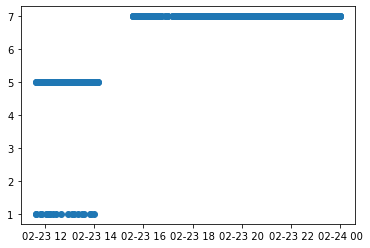

In [229]:
fif, ax = plt.subplots()
ax.scatter(dataraw['time'].values, mask_crit)

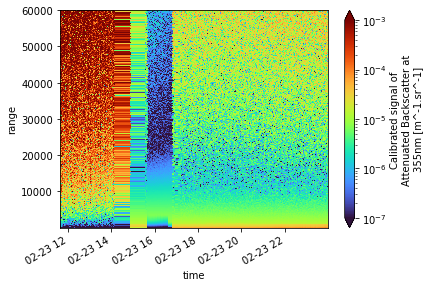

In [234]:
from matplotlib.colors import LogNorm
dataset_to_write['Total_Calib_Attn_Backscatter_355'].plot(x='time', y='range', cmap='turbo', norm=LogNorm(vmin=1e-7, vmax=1e-3))

In [240]:
dataset_to_write['flags'] = mask_crit
dataset_to_write = add_attrs_variables(dataset_to_write, 'flags', 'flags: O=validated profiles, 1=invalidated profiles, 2=noisy profiles, \n4=clouds in calibration area', 
                                       None, None, None)

dataset_to_write

<xarray.Dataset>
Dimensions:                           (range: 4000, time: 1234)
Coordinates:
  * time                              (time) datetime64[ns] 2018-02-23T11:38:...
  * range                             (range) float32 15.0 30.0 ... 6e+04
Data variables: (12/16)
    Altitude                          (range) float32 171.0 186.0 ... 6.016e+04
    Raw_AnalogNR_355                  (time, range) float64 965.9 ... 3.403e+09
    Raw_AnalogNR_532                  (time, range) float64 1.105e+03 ... 3.3...
    Model_Pressure                    (time, range) float64 1.011e+05 ... -421.4
    Model_Temperature                 (time, range) float64 274.8 ... 279.1
    Model_Molecular_Backscatter_355   (time, range) float64 9.131e-06 ... -9....
    ...                                ...
    Total_Calib_Attn_Backscatter_532  (time, range) float64 -3.306e-10 ... 4....
    Total_ScattRatio_355              (time, range) float64 9.632e-05 ... -3....
    Total_ScattRatio_532              (time, range) float64 -0.0001986 ... -7...
    C_355                             (time) object None None None ... None None
    C_532                             (time) object None None None ... None None
    flags                             (time) int64 5 1 1 5 5 5 5 ... 7 7 7 7 7 7
Attributes:
    Instrument_name:         IPSL HiPerformance multi-wavelength Raman Lidar
    Start_Datetime:          2018-02-23T11:38:07.000000256
    End_Datetime:            2018-02-23T23:59:24.000000000
    Latitude:                48.71799850463867
    Longitude:               2.2070000171661377
    Responsable_data:        N.M.Phuong Nguyen (phuong.nguyen@latmos.ipsl.fr)
    Responsable_instrument:  Christophe Pietras (christophe.pietras@lmd.ipsl.fr)

In [250]:
dict_attrs = {
    "long_name":'Total scattering ratio of signal at 532nm = Calibrated signal of Attenuated Backscatter / Attenuated molecular backscatter ',
    "unit":None,
    "resolution":None,
    "height_of_calibration":'3000,4000'
}

for key, value in dict_attrs.items():
    if value is not None:
        dataset_to_write['Total_ScattRatio_355'].attrs[key]:value 
    
        

In [2]:
data = xr.open_dataset('/home/nmpnguyen/tmp_file.nc')

In [7]:
pd.to_datetime(data.attrs['start_time']).strftime('%Y%m'), pd.to_datetime(data.attrs['start_time']).strftime('%Y')


('202001', '2020')

In [7]:
sorted(Path('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/').glob('2020*/2020*sir83*/elda'))

[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8310/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8311/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8312/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8313/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8314/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8315/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8318/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8319/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8320/elda'),
 PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8321/elda'),
 PosixPath('/homedat

In [189]:
from matplotlib.colors import LogNorm

code_file_NR_noRaman = 83
variables_by_products = {
    'elda' : ['backscatter', 'error_backscatter'],
    'elic' : ['attenuated_backscatter', 'attenuated_backscatter_detection_wavelength'],
    'elpp' : ['range_corrected_signal', 'range_corrected_signal_detection_wavelength'],
    'hirelpp' : ['range_corrected_signal']
}
dim_to_concat = {
    'elda' : ['time', 'latitude', 'longitude'],
    'elpp' : ['time', 'channel'],
    'elic' : ['time'],
    'hirelpp' : ['time']
}
pattern_path = {
    'elda' : {'355':'sir_003_0355', '532':'sir_003_0532'},
    'elic' : {'355':'0000983', '532':'0000982', 'both':'0000987'},
    'elpp' : {'355':'0000983', '532':'0000982'},
    'hirelpp':{'both':'sir_009_0000987'}
}

In [178]:
print(list(pattern_path['elic'].keys()))
test = {key : pattern_path['elic'][key] for key in pattern_path['elic'].keys()}
test  

['355', '532', 'both']


{'355': '0000983', '532': '0000982', 'both': '0000987'}

In [192]:
def get_listpaths_by_product(dayfolder, product_chosen):
    scc_products = {
        'elda':'elda', 
        'elic':'elic', 
        'elpp':'elpp', 
        'hirelpp':'hirelpp'
    }
#     list532 = sorted(Path(dayfolder).glob(f'*sir{code_file_NR_noRaman}*/{scc_products[product_chosen]}/*{pattern_path[product_chosen][1]}*.nc'))
#     list355 = sorted(Path(dayfolder).glob(f'*sir{code_file_NR_noRaman}*/{scc_products[product_chosen]}/*{pattern_path[product_chosen][0]}*.nc'))
#     listpaths = {
#         '532' : list532,
#         '355' : list355
#     }

    listpaths = {key : sorted(Path(dayfolder).glob(f'*sir{code_file_NR_noRaman}*/{scc_products[product_chosen]}/*{pattern_path[product_chosen][key]}*.nc')) for key in pattern_path[product_chosen].keys()}
    return listpaths

def concat_data_by_product(dayfolder, listpaths, product_chosen, variables):
    def get_output_savedpath(dayfolder, product_chosen, wavelength):
        output_savedpath = Path(dayfolder, f'{product_chosen}_{wavelength}_concat_data.nc')
        return output_savedpath
#     wavelength = ['532', '355']
    for wavelength in listpaths.keys():
        data_vars = None
        for file in listpaths[wavelength]:
            print(file)
            data = xr.open_dataset(file)
            if data_vars is None:
                data_vars = data[variables]
                print(data_vars)
            else:
                data_vars = xr.combine_nested([data_vars, data[variables]], concat_dim=['time'])       

        savedpath = get_output_savedpath(dayfolder, product_chosen, wavelength)
        print(savedpath)
        data_vars.to_netcdf(savedpath, 'w')
    return data_vars

In [198]:
listfolders = sorted(Path('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/').glob('2020*'))

product_chosen = 'elic'
for folder in listfolders[:1]:
    print(folder)
    listfiles = get_listpaths_by_product(folder, product_chosen)
    print(listfiles)
    variables = variables_by_products[product_chosen]
    data_concat = concat_data_by_product(folder, listfiles, product_chosen, variables)
#     listfiles = sorted(folder.glob(f'*sir{code_file_NR_noRaman}*/{scc_products[product_chosen]}/*{pattern_path[product_chosen][0]}*.nc'))
#     for file in listfiles:
#         print(file)
#         data = xr.open_dataset(file)
#         print(data[variables_by_products[product_chosen]])
#         if data_vars is None:
#             data_vars = data[variables_by_products[product_chosen]]
#             print(data_vars)
#         else:
#             data_vars = xr.combine_nested([data_vars, data[variables_by_products[product_chosen]]], concat_dim=['time'])


/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206
{'355': [PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8310/elic/sir_003_0000983_202002061000_202002061100_20200206sir8310_elic_v5.2.3.nc'), PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8311/elic/sir_003_0000983_202002061100_202002061200_20200206sir8311_elic_v5.2.3.nc'), PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8312/elic/sir_003_0000983_202002061200_202002061300_20200206sir8312_elic_v5.2.3.nc'), PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8313/elic/sir_003_0000983_202002061300_202002061400_20200206sir8313_elic_v5.2.3.nc'), PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8314/elic/sir_003_0000983_202002061400_202002061500_20200206sir8314_elic_v5.2.3.nc'), PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/202002

/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8315/elic/sir_003_0000983_202002061500_202002061600_20200206sir8315_elic_v5.2.3.nc
/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8318/elic/sir_003_0000983_202002061800_202002061900_20200206sir8318_elic_v5.2.3.nc
/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8319/elic/sir_003_0000983_202002061900_202002062000_20200206sir8319_elic_v5.2.3.nc
/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8320/elic/sir_003_0000983_202002062000_202002062100_20200206sir8320_elic_v5.2.3.nc
/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8321/elic/sir_003_0000983_202002062100_202002062200_20200206sir8321_elic_v5.2.3.nc
/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8322/elic/sir_003_0000983_202002062200_202002062300_20200206sir8322_elic_v5.2.3.nc
/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20

In [199]:
# xr.open_dataset('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8323/hirelpp/sir_009_0000987_202002062300_202002062359_20200206sir8323_hirelpp_v5.2.3.nc')

data_concat

<xarray.Dataset>
Dimensions:                                      (channel: 2, level: 1050, time: 1424)
Coordinates:
    altitude                                     (time, level) float64 418.5 ...
  * time                                         (time) datetime64[ns] 2020-0...
Dimensions without coordinates: channel, level
Data variables:
    attenuated_backscatter                       (channel, time, level) float64 ...
    attenuated_backscatter_detection_wavelength  (time, channel) float64 355....

In [133]:
import sys
sys.path.append('/homedata/nmpnguyen/IPRAL/SCC_produits/output/')
import config_scc_products as cfg
print(cfg.scc_products)
for product in cfg.scc_products:
    print(type(product))

{'elda': 'elda', 'elic': 'elic', 'elpp': 'elpp', 'hirelpp': 'hirelpp'}
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
